# FPGheArt - Week 2 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653


(IBM says these colors are good also for color blinds. We hope so!)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import time

### Data (strings) and splitting

In [2]:
fname="DATA/sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter=',',
                   usecols= (0,1), unpack=True, dtype = str)

In [3]:
N = len(sy)
print(f"Number of total samples {N}")
Ls = len(sx[0])
print(f"Lenght of a sample {Ls}")

print(f"Sample: {sx[0]}, label: {sy[0]}")

perc_train = 0.8
N_train = int(N*perc_train)
N_test = N -N_train
print(f'\ndata:{N}\ntrain: {N_train}\ntest: {N_test}')

Number of total samples 3000
Lenght of a sample 16
Sample: AAGGTCTGCCGGCCGA, label: 1

data:3000
train: 2400
test: 600


In [4]:
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc = {Q[i]: i for i in range(Nc)}
print(f"One-hot encoding dictionary: {onehc}")

One-hot encoding dictionary: {'A': 0, 'C': 1, 'G': 2, 'T': 3}


### Data conversion: One-Hot Encoding



In [5]:
y = sy.astype(int)

L = Ls*Nc
print(f"Product of lenght ({Ls}) and character possibilities ({Nc}): {L}\n")

x= np.zeros((N,L))

for n in range(N):
    for i in range(Ls):
        x[n][i*4 + onehc[sx[n][i]]] = 1
print(f"Original sequence:\n {sx[0]}\n")
print(f"Encoded sequence:\n {x[0]}")

Product of lenght (16) and character possibilities (4): 64

Original sequence:
 AAGGTCTGCCGGCCGA

Encoded sequence:
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


### Split train/test - validation

In [6]:
(x_train, y_train) = (x[:N_train], y[:N_train])
(x_test, y_test) = (x[N_train:], y[N_train:])
print(f"Ratio between y_train labels sum and train samples: {y_train.sum() / N_train}")
print(f"Ratio between y_test  labels sum and test samples: {y_test.sum() / N_test}")


Ratio between y_train labels sum and train samples: 0.24333333333333335
Ratio between y_test  labels sum and test samples: 0.25833333333333336


### Definition of model in Keras

In [7]:
np.random.seed(123)

model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

In [25]:
fit = model.fit(x_train, y_train,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True, verbose = 0)
pd.DataFrame(fit.history)

,loss,accuracy,val_loss,val_accuracy
0,0.000164,1.000000,1.915582,0.800000
1,0.000387,1.000000,1.913073,0.796667
2,0.000202,1.000000,1.952410,0.801667
3,0.000173,1.000000,1.957754,0.801667
4,0.000108,1.000000,1.969717,0.803333
5,0.000135,1.000000,1.976647,0.798333
6,0.000144,1.000000,1.987434,0.798333
7,0.000141,1.000000,1.997455,0.800000
8,0.000417,1.000000,2.006931,0.798333
9,0.000107,1.000000,2.015350,0.798333


19/19 [==============================] - 0s 1ms/step - loss: 0.3050 - accuracy: 0.8833
Final Test loss: 0.3050372302532196
Final Test accuracy: 0.8833333253860474


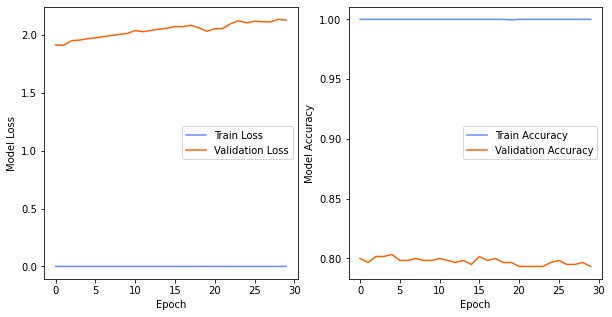

In [43]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# summarize history for loss
ax1.plot(fit.history['loss'], label = 'Train Loss', color = '#648FFF')
ax1.plot(fit.history['val_loss'], label = 'Validation Loss', color = '#FE6100')

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit.history['accuracy'], label = 'Train Accuracy', color =  '#648FFF')
ax2.plot(fit.history['val_accuracy'], label = 'Validation Accuracy', color = '#FE6100')

ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

## Data augmentation

In this chapter we try to reshuffle randomly the bases in the sequences keeping the labels constant. 

We are aware of the fact that, in doing so, we introduce some noise as the key for labelling may be in certain cases lost during the reshuffle. Anyhow, given the huge increase in the test samples (15 times), we hope to achieve a better score on the test set.

The discussion on whether one or the other effect is higher is done comparing the results at the end of this section.

In [28]:
#data augementation trough shuffling. Every 16 combiations are tried for each sequence
augval = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(16)] for v,vy in zip(sx[:N_train],y[:N_train])]).reshape(38400,2)
augsx = augval[:,0]
augy_train = augval[:,1].astype(int)

In [29]:
#One-Hot encoding for the augmented sequences
augx_train = np.zeros((N_train*16,L))

for n in range(N_train*16):
    for i in range(Ls):
        augx_train[n][i*4 + onehc[augsx[n][i]]] = 1
aug_N_train = N_train*16

### Split train/test - validation

In [30]:
#ModelFit with Augmented Data
fit_augmented = model.fit(augx_train, augy_train,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True, verbose = 0)


19/19 [==============================] - 0s 1ms/step - loss: 0.3050 - accuracy: 0.8833

Test loss: 0.3050372302532196
Test accuracy: 0.8833333253860474


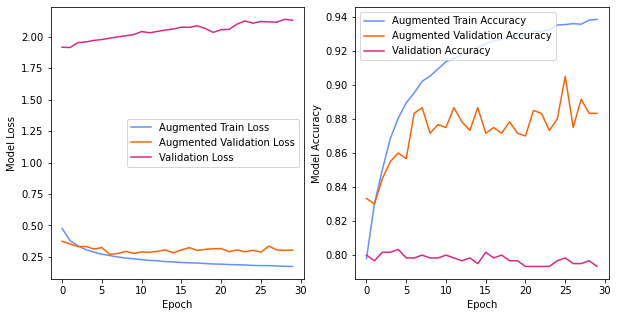

In [44]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# looking training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# summarize history for loss
ax1.plot(fit_augmented.history['loss'], label = 'Augmented Train Loss',color =  '#648FFF')
ax1.plot(fit_augmented.history['val_loss'], label = 'Augmented Validation Loss', color = '#FE6100')
ax1.plot(fit.history['val_loss'], label = 'Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_augmented.history['accuracy'], label = 'Augmented Train Accuracy', color =  '#648FFF')
ax2.plot(fit_augmented.history['val_accuracy'], label = 'Augmented Validation Accuracy',color = '#FE6100')
ax2.plot(fit.history['val_accuracy'], label = 'Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

Even with the randomization introduced, the network provides better results than the previous case. In fact, the validation accuracy is higher than before, while the loss also diminishes. 

Moreover, the train accuracy is not stuck at 1 as in the previous case. This ensures the network to continue learning trough different epochs, so increasing the validation accuracy.

## GridSearch for parameter optimization

In the following, we define a GridSearch method for finding the best parameters to fed into the network. 
A cell is entirely commented, as it runs about 500 minimizations (about 30min CPU/GPU time).
Results are provided as an imported csv file. 

In [15]:
def create_DNN(activation, dropout_rate, n_layers = 2, l_shapes= [L/2, L/4]):
    model = Sequential()

    model.add(Dense(L,input_shape=(L,),activation = activation))
    for i in range(n_layers):
        model.add(Dense(l_shapes[i],activation = activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation="sigmoid"))
    return model


In [16]:
def compile_model(optimizer=keras.optimizers.Adam(), activation = "relu", dropout_rate = 0.2, n_layers=2, l_shapes= [L/2, L/4]):
    # create the mode
    model=create_DNN(activation, dropout_rate, n_layers, l_shapes)
    # compile the model
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


# WARNING!!!

The cell below starts a quite heavy GridSearch. It takes abous 30min to finish the hole search. 
We report below the (fortunately) saved results we get after running with the shown parameters.

In [ ]:
# # call Keras scikit wrapper
# model_gridsearch = KerasClassifier(build_fn = compile_model)

# # list of allowed optional arguments for the optimizer, see `compile_model()`
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# # define parameter dictionary
# param_grid = dict(optimizer=optimizer, activation = activation, dropout_rate=dropout_rate)
# # call scikit grid search module
# grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
# grid_result = grid.fit(x_train,y_train, epochs=30, batch_size = 50, shuffle = True)


In [68]:
df_GridSearch = pd.read_csv("DATA/GridSearch_results.csv", index_col = False)
df_GridSearch = df_GridSearch.iloc[:,1:]
df_GridSearch.sort_values(by = "rank_test_score", ascending = True)
df_GridSearch

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_dropout_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.744381,0.285944,0.156408,0.024191,softmax,0.0,SGD,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
1,1.683135,0.014039,0.144131,0.002644,softmax,0.0,RMSprop,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
2,1.585771,0.185988,0.149712,0.002874,softmax,0.0,Adagrad,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.256667,0.766667,0.748333,0.635000,0.218572,484
3,1.715497,0.206373,0.176459,0.028340,softmax,0.0,Adadelta,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
4,1.809999,0.253402,0.154890,0.020702,softmax,0.0,Adam,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.922601,0.006654,0.083078,0.001907,linear,0.9,Adagrad,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.768333,0.746667,0.768333,0.746667,0.757500,0.010833,266
556,1.012483,0.068138,0.090344,0.008606,linear,0.9,Adadelta,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.578333,0.568333,0.410000,0.601667,0.539583,0.075786,529
557,1.124401,0.091408,0.143794,0.098108,linear,0.9,Adam,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.783333,0.753333,0.771667,0.763333,0.767917,0.011016,154
558,0.996102,0.032718,0.093340,0.009601,linear,0.9,Adamax,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.780000,0.743333,0.765000,0.771667,0.765000,0.013591,206


In [69]:
df_GridSearch[df_GridSearch["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_dropout_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
249,1.066452,0.008873,0.083023,0.000802,relu,0.5,Adam,"{'activation': 'relu', 'dropout_rate': 0.5, 'o...",0.805,0.793333,0.801667,0.808333,0.802083,0.005575,1


The best output is given using Adam, a 0.5 dropout rate on the third layer and "ReLU" as activation function

## Layers Dimension Optimization



To get better result we can optimize the layer size, by decreasing the number of total neurons and reducing overfitting. 

### Definition of model in Keras

In [37]:
 # call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model)

# # define parameter dictionary
l_shapes= [(L/8,L/16), (L/16, L/8), (L/32, L/16), (L/16, L/32), (L/32, L/32), (L/16, L/16), (L/8, L/8), (L/2,L/4), (L/2,L/2), (L/4,L/2), (L/4,L/8), (L/8,L/4), (L/4, L/4), (L,L), (2*L,2*L)]
dropout_rate = [0.5]
param_grid = dict(l_shapes=l_shapes, dropout_rate =dropout_rate)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=30, batch_size = 50, shuffle = True)


Epoch 1/30
36/36 [==============================] - 1s 1ms/step - loss: 0.6356 - accuracy: 0.7255
Epoch 2/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5680 - accuracy: 0.7516
Epoch 3/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5325 - accuracy: 0.7593
Epoch 4/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5194 - accuracy: 0.7532
Epoch 5/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4915 - accuracy: 0.7714
Epoch 6/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4966 - accuracy: 0.7820
Epoch 7/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4739 - accuracy: 0.7874
Epoch 8/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4720 - accuracy: 0.8007
Epoch 9/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4543 - accuracy: 0.7957
Epoch 10/30
36/36 [==============================] - 0s 2ms/step - loss: 0.4340 - accuracy: 0.8226
Epoch 11/30
36/36 [

36/36 [==============================] - 0s 546us/step - loss: 0.4905 - accuracy: 0.7458
Epoch 22/30
36/36 [==============================] - 0s 577us/step - loss: 0.4803 - accuracy: 0.7453
Epoch 23/30
36/36 [==============================] - 0s 627us/step - loss: 0.4683 - accuracy: 0.7503
Epoch 24/30
36/36 [==============================] - 0s 565us/step - loss: 0.4767 - accuracy: 0.7412
Epoch 25/30
36/36 [==============================] - 0s 576us/step - loss: 0.4525 - accuracy: 0.7544
Epoch 26/30
36/36 [==============================] - 0s 636us/step - loss: 0.4546 - accuracy: 0.7601
Epoch 27/30
36/36 [==============================] - 0s 579us/step - loss: 0.4350 - accuracy: 0.7809
Epoch 28/30
36/36 [==============================] - 0s 599us/step - loss: 0.4666 - accuracy: 0.7416
Epoch 29/30
36/36 [==============================] - 0s 579us/step - loss: 0.4461 - accuracy: 0.7561
Epoch 30/30
19/19 [==============================] - 0s 429us/step - loss: 0.4833 - accuracy: 0.7667
Ep

36/36 [==============================] - 0s 553us/step - loss: 0.3779 - accuracy: 0.7460
Epoch 10/30
36/36 [==============================] - 0s 551us/step - loss: 0.3592 - accuracy: 0.7518
Epoch 11/30
36/36 [==============================] - 0s 581us/step - loss: 0.3120 - accuracy: 0.7644
Epoch 12/30
36/36 [==============================] - 0s 596us/step - loss: 0.3084 - accuracy: 0.7574
Epoch 13/30
36/36 [==============================] - 0s 579us/step - loss: 0.2833 - accuracy: 0.8095
Epoch 14/30
36/36 [==============================] - 0s 582us/step - loss: 0.2700 - accuracy: 0.9087
Epoch 15/30
36/36 [==============================] - 0s 575us/step - loss: 0.2515 - accuracy: 0.9093
Epoch 16/30
36/36 [==============================] - 0s 584us/step - loss: 0.2325 - accuracy: 0.9212
Epoch 17/30
36/36 [==============================] - 0s 554us/step - loss: 0.2282 - accuracy: 0.9272
Epoch 18/30
36/36 [==============================] - 0s 656us/step - loss: 0.2248 - accuracy: 0.9346
Ep

36/36 [==============================] - 0s 541us/step - loss: 0.3472 - accuracy: 0.7690
Epoch 29/30
36/36 [==============================] - 0s 565us/step - loss: 0.3507 - accuracy: 0.7655
Epoch 30/30
19/19 [==============================] - 0s 490us/step - loss: 0.5515 - accuracy: 0.7483
Epoch 1/30
36/36 [==============================] - 0s 569us/step - loss: 0.6439 - accuracy: 0.7272
Epoch 2/30
36/36 [==============================] - 0s 513us/step - loss: 0.5968 - accuracy: 0.7445
Epoch 3/30
36/36 [==============================] - 0s 554us/step - loss: 0.5684 - accuracy: 0.7546
Epoch 4/30
36/36 [==============================] - 0s 546us/step - loss: 0.5651 - accuracy: 0.7494
Epoch 5/30
36/36 [==============================] - 0s 550us/step - loss: 0.5516 - accuracy: 0.7332
Epoch 6/30
36/36 [==============================] - 0s 548us/step - loss: 0.5467 - accuracy: 0.7473
Epoch 7/30
36/36 [==============================] - 0s 539us/step - loss: 0.5423 - accuracy: 0.7398
Epoch 8/3

36/36 [==============================] - 0s 578us/step - loss: 0.2496 - accuracy: 0.8448
Epoch 17/30
36/36 [==============================] - 0s 576us/step - loss: 0.2330 - accuracy: 0.8676
Epoch 18/30
36/36 [==============================] - 0s 563us/step - loss: 0.2004 - accuracy: 0.8706
Epoch 19/30
36/36 [==============================] - 0s 571us/step - loss: 0.2027 - accuracy: 0.8725
Epoch 20/30
36/36 [==============================] - 0s 564us/step - loss: 0.1932 - accuracy: 0.8744
Epoch 21/30
36/36 [==============================] - 0s 574us/step - loss: 0.1727 - accuracy: 0.8857
Epoch 22/30
36/36 [==============================] - 0s 555us/step - loss: 0.1818 - accuracy: 0.8757
Epoch 23/30
36/36 [==============================] - 0s 553us/step - loss: 0.1857 - accuracy: 0.8681
Epoch 24/30
36/36 [==============================] - 0s 551us/step - loss: 0.1832 - accuracy: 0.8740
Epoch 25/30
36/36 [==============================] - 0s 581us/step - loss: 0.1695 - accuracy: 0.8794
Ep

36/36 [==============================] - 0s 562us/step - loss: 0.6041 - accuracy: 0.7545
Epoch 5/30
36/36 [==============================] - 0s 570us/step - loss: 0.5904 - accuracy: 0.7615
Epoch 6/30
36/36 [==============================] - 0s 562us/step - loss: 0.5728 - accuracy: 0.7787
Epoch 7/30
36/36 [==============================] - 0s 556us/step - loss: 0.5745 - accuracy: 0.7648
Epoch 8/30
36/36 [==============================] - 0s 586us/step - loss: 0.5702 - accuracy: 0.7638
Epoch 9/30
36/36 [==============================] - 0s 559us/step - loss: 0.5569 - accuracy: 0.7768
Epoch 10/30
36/36 [==============================] - 0s 537us/step - loss: 0.5711 - accuracy: 0.7532
Epoch 11/30
36/36 [==============================] - 0s 557us/step - loss: 0.5841 - accuracy: 0.7341
Epoch 12/30
36/36 [==============================] - 0s 519us/step - loss: 0.5561 - accuracy: 0.7666
Epoch 13/30
36/36 [==============================] - 0s 548us/step - loss: 0.5528 - accuracy: 0.7681
Epoch 1

36/36 [==============================] - 0s 554us/step - loss: 0.5490 - accuracy: 0.7634
Epoch 24/30
36/36 [==============================] - 0s 577us/step - loss: 0.5637 - accuracy: 0.7559
Epoch 25/30
36/36 [==============================] - 0s 541us/step - loss: 0.5487 - accuracy: 0.7652
Epoch 26/30
36/36 [==============================] - 0s 551us/step - loss: 0.5549 - accuracy: 0.7611
Epoch 27/30
36/36 [==============================] - 0s 578us/step - loss: 0.5515 - accuracy: 0.7638
Epoch 28/30
36/36 [==============================] - 0s 545us/step - loss: 0.5620 - accuracy: 0.7529
Epoch 29/30
36/36 [==============================] - 0s 550us/step - loss: 0.5500 - accuracy: 0.7635
Epoch 30/30
19/19 [==============================] - 0s 453us/step - loss: 0.5642 - accuracy: 0.7483
Epoch 1/30
36/36 [==============================] - 0s 562us/step - loss: 0.6348 - accuracy: 0.7476
Epoch 2/30
36/36 [==============================] - 0s 551us/step - loss: 0.5622 - accuracy: 0.7608
Epoc

36/36 [==============================] - 0s 577us/step - loss: 0.5807 - accuracy: 0.7390
Epoch 12/30
36/36 [==============================] - 0s 563us/step - loss: 0.5729 - accuracy: 0.7469
Epoch 13/30
36/36 [==============================] - 0s 556us/step - loss: 0.5583 - accuracy: 0.7628
Epoch 14/30
36/36 [==============================] - 0s 580us/step - loss: 0.5707 - accuracy: 0.7466
Epoch 15/30
36/36 [==============================] - 0s 557us/step - loss: 0.5595 - accuracy: 0.7582
Epoch 16/30
36/36 [==============================] - 0s 552us/step - loss: 0.5610 - accuracy: 0.7556
Epoch 17/30
36/36 [==============================] - 0s 551us/step - loss: 0.5697 - accuracy: 0.7452
Epoch 18/30
36/36 [==============================] - 0s 591us/step - loss: 0.5632 - accuracy: 0.7517
Epoch 19/30
36/36 [==============================] - 0s 562us/step - loss: 0.5475 - accuracy: 0.7677
Epoch 20/30
36/36 [==============================] - 0s 656us/step - loss: 0.5525 - accuracy: 0.7618
Ep

19/19 [==============================] - 0s 459us/step - loss: 0.7728 - accuracy: 0.7817
Epoch 1/30
36/36 [==============================] - 0s 549us/step - loss: 0.6821 - accuracy: 0.7131
Epoch 2/30
36/36 [==============================] - 0s 551us/step - loss: 0.6201 - accuracy: 0.7725
Epoch 3/30
36/36 [==============================] - 0s 562us/step - loss: 0.5932 - accuracy: 0.7577
Epoch 4/30
36/36 [==============================] - 0s 535us/step - loss: 0.5825 - accuracy: 0.7531
Epoch 5/30
36/36 [==============================] - 0s 557us/step - loss: 0.5784 - accuracy: 0.7479
Epoch 6/30
36/36 [==============================] - 0s 557us/step - loss: 0.5650 - accuracy: 0.7710
Epoch 7/30
36/36 [==============================] - 0s 549us/step - loss: 0.5725 - accuracy: 0.7652
Epoch 8/30
36/36 [==============================] - 0s 556us/step - loss: 0.5711 - accuracy: 0.7531
Epoch 9/30
36/36 [==============================] - 0s 548us/step - loss: 0.5602 - accuracy: 0.7608
Epoch 10/30

36/36 [==============================] - 0s 552us/step - loss: 0.3005 - accuracy: 0.8488
Epoch 19/30
36/36 [==============================] - 0s 588us/step - loss: 0.2913 - accuracy: 0.8419
Epoch 20/30
36/36 [==============================] - 0s 573us/step - loss: 0.2853 - accuracy: 0.8695
Epoch 21/30
36/36 [==============================] - 0s 549us/step - loss: 0.2784 - accuracy: 0.8708
Epoch 22/30
36/36 [==============================] - 0s 607us/step - loss: 0.2655 - accuracy: 0.8823
Epoch 23/30
36/36 [==============================] - 0s 556us/step - loss: 0.2590 - accuracy: 0.8587
Epoch 24/30
36/36 [==============================] - 0s 556us/step - loss: 0.2427 - accuracy: 0.8807
Epoch 25/30
36/36 [==============================] - 0s 607us/step - loss: 0.2506 - accuracy: 0.8746
Epoch 26/30
36/36 [==============================] - 0s 591us/step - loss: 0.2462 - accuracy: 0.8760
Epoch 27/30
36/36 [==============================] - 0s 549us/step - loss: 0.2515 - accuracy: 0.8612
Ep

36/36 [==============================] - 0s 582us/step - loss: 0.4234 - accuracy: 0.7909
Epoch 7/30
36/36 [==============================] - 0s 588us/step - loss: 0.3992 - accuracy: 0.8110
Epoch 8/30
36/36 [==============================] - 0s 632us/step - loss: 0.3736 - accuracy: 0.8054
Epoch 9/30
36/36 [==============================] - 0s 596us/step - loss: 0.3215 - accuracy: 0.8380
Epoch 10/30
36/36 [==============================] - 0s 588us/step - loss: 0.3246 - accuracy: 0.8351
Epoch 11/30
36/36 [==============================] - 0s 550us/step - loss: 0.2881 - accuracy: 0.8566
Epoch 12/30
36/36 [==============================] - 0s 586us/step - loss: 0.2599 - accuracy: 0.8789
Epoch 13/30
36/36 [==============================] - 0s 548us/step - loss: 0.2466 - accuracy: 0.8967
Epoch 14/30
36/36 [==============================] - 0s 562us/step - loss: 0.2208 - accuracy: 0.9078
Epoch 15/30
36/36 [==============================] - 0s 551us/step - loss: 0.1786 - accuracy: 0.9415
Epoch

36/36 [==============================] - 0s 644us/step - loss: 0.0243 - accuracy: 0.9936
Epoch 26/30
36/36 [==============================] - 0s 613us/step - loss: 0.0224 - accuracy: 0.9934
Epoch 27/30
36/36 [==============================] - 0s 589us/step - loss: 0.0242 - accuracy: 0.9946
Epoch 28/30
36/36 [==============================] - 0s 581us/step - loss: 0.0239 - accuracy: 0.9922
Epoch 29/30
36/36 [==============================] - 0s 580us/step - loss: 0.0258 - accuracy: 0.9941
Epoch 30/30
19/19 [==============================] - 0s 461us/step - loss: 1.2141 - accuracy: 0.8083
Epoch 1/30
36/36 [==============================] - 0s 581us/step - loss: 0.5737 - accuracy: 0.7408
Epoch 2/30
36/36 [==============================] - 0s 585us/step - loss: 0.4786 - accuracy: 0.7840
Epoch 3/30
36/36 [==============================] - 0s 585us/step - loss: 0.4439 - accuracy: 0.7802
Epoch 4/30
36/36 [==============================] - 0s 609us/step - loss: 0.4260 - accuracy: 0.7974
Epoch 

36/36 [==============================] - 0s 634us/step - loss: 0.1020 - accuracy: 0.9756
Epoch 14/30
36/36 [==============================] - 0s 582us/step - loss: 0.0995 - accuracy: 0.9681
Epoch 15/30
36/36 [==============================] - 0s 635us/step - loss: 0.0740 - accuracy: 0.9779
Epoch 16/30
36/36 [==============================] - 0s 600us/step - loss: 0.0531 - accuracy: 0.9901
Epoch 17/30
36/36 [==============================] - 0s 641us/step - loss: 0.0507 - accuracy: 0.9900
Epoch 18/30
36/36 [==============================] - 0s 604us/step - loss: 0.0349 - accuracy: 0.9938
Epoch 19/30
36/36 [==============================] - 0s 603us/step - loss: 0.0357 - accuracy: 0.9920
Epoch 20/30
36/36 [==============================] - 0s 603us/step - loss: 0.0320 - accuracy: 0.9916
Epoch 21/30
36/36 [==============================] - 0s 605us/step - loss: 0.0251 - accuracy: 0.9954
Epoch 22/30
36/36 [==============================] - 0s 634us/step - loss: 0.0195 - accuracy: 0.9974
Ep

36/36 [==============================] - 0s 581us/step - loss: 0.5660 - accuracy: 0.7555
Epoch 2/30
36/36 [==============================] - 0s 638us/step - loss: 0.4807 - accuracy: 0.7621
Epoch 3/30
36/36 [==============================] - 0s 593us/step - loss: 0.4594 - accuracy: 0.7746
Epoch 4/30
36/36 [==============================] - 0s 601us/step - loss: 0.4206 - accuracy: 0.8062
Epoch 5/30
36/36 [==============================] - 0s 599us/step - loss: 0.3660 - accuracy: 0.8305
Epoch 6/30
36/36 [==============================] - 0s 564us/step - loss: 0.3019 - accuracy: 0.8705
Epoch 7/30
36/36 [==============================] - 0s 584us/step - loss: 0.2405 - accuracy: 0.9093
Epoch 8/30
36/36 [==============================] - 0s 588us/step - loss: 0.2050 - accuracy: 0.9315
Epoch 9/30
36/36 [==============================] - 0s 620us/step - loss: 0.1553 - accuracy: 0.9491
Epoch 10/30
36/36 [==============================] - 0s 558us/step - loss: 0.1178 - accuracy: 0.9567
Epoch 11/3

36/36 [==============================] - 0s 560us/step - loss: 0.0215 - accuracy: 0.9968
Epoch 21/30
36/36 [==============================] - 0s 568us/step - loss: 0.0200 - accuracy: 0.9957
Epoch 22/30
36/36 [==============================] - 0s 585us/step - loss: 0.0227 - accuracy: 0.9938
Epoch 23/30
36/36 [==============================] - 0s 577us/step - loss: 0.0138 - accuracy: 0.9983
Epoch 24/30
36/36 [==============================] - 0s 587us/step - loss: 0.0140 - accuracy: 0.9970
Epoch 25/30
36/36 [==============================] - 0s 579us/step - loss: 0.0133 - accuracy: 0.9980
Epoch 26/30
36/36 [==============================] - 0s 578us/step - loss: 0.0116 - accuracy: 0.9970
Epoch 27/30
36/36 [==============================] - 0s 588us/step - loss: 0.0114 - accuracy: 0.9984
Epoch 28/30
36/36 [==============================] - 0s 605us/step - loss: 0.0128 - accuracy: 0.9994
Epoch 29/30
36/36 [==============================] - 0s 565us/step - loss: 0.0092 - accuracy: 0.9993
Ep

36/36 [==============================] - 0s 577us/step - loss: 0.2078 - accuracy: 0.9288
Epoch 9/30
36/36 [==============================] - 0s 573us/step - loss: 0.1862 - accuracy: 0.9370
Epoch 10/30
36/36 [==============================] - 0s 629us/step - loss: 0.1304 - accuracy: 0.9619
Epoch 11/30
36/36 [==============================] - 0s 630us/step - loss: 0.1053 - accuracy: 0.9705
Epoch 12/30
36/36 [==============================] - 0s 577us/step - loss: 0.0764 - accuracy: 0.9781
Epoch 13/30
36/36 [==============================] - 0s 612us/step - loss: 0.0525 - accuracy: 0.9833
Epoch 14/30
36/36 [==============================] - 0s 565us/step - loss: 0.0354 - accuracy: 0.9917
Epoch 15/30
36/36 [==============================] - 0s 589us/step - loss: 0.0340 - accuracy: 0.9922
Epoch 16/30
36/36 [==============================] - 0s 665us/step - loss: 0.0256 - accuracy: 0.9951
Epoch 17/30
36/36 [==============================] - 0s 668us/step - loss: 0.0212 - accuracy: 0.9962
Epo

36/36 [==============================] - 0s 586us/step - loss: 0.0502 - accuracy: 0.9725
Epoch 28/30
36/36 [==============================] - 0s 584us/step - loss: 0.0515 - accuracy: 0.9601
Epoch 29/30
36/36 [==============================] - 0s 565us/step - loss: 0.0429 - accuracy: 0.9738
Epoch 30/30
19/19 [==============================] - 0s 456us/step - loss: 1.3764 - accuracy: 0.7733
Epoch 1/30
36/36 [==============================] - 0s 544us/step - loss: 0.6200 - accuracy: 0.6788
Epoch 2/30
36/36 [==============================] - 0s 596us/step - loss: 0.5199 - accuracy: 0.7726
Epoch 3/30
36/36 [==============================] - 0s 560us/step - loss: 0.5038 - accuracy: 0.7654
Epoch 4/30
36/36 [==============================] - 0s 573us/step - loss: 0.4679 - accuracy: 0.7648
Epoch 5/30
36/36 [==============================] - 0s 578us/step - loss: 0.4538 - accuracy: 0.7706
Epoch 6/30
36/36 [==============================] - 0s 571us/step - loss: 0.4424 - accuracy: 0.7732
Epoch 7/

36/36 [==============================] - 0s 565us/step - loss: 0.1529 - accuracy: 0.9465
Epoch 16/30
36/36 [==============================] - 0s 568us/step - loss: 0.1231 - accuracy: 0.9731
Epoch 17/30
36/36 [==============================] - 0s 592us/step - loss: 0.1015 - accuracy: 0.9806
Epoch 18/30
36/36 [==============================] - 0s 589us/step - loss: 0.1043 - accuracy: 0.9805
Epoch 19/30
36/36 [==============================] - 0s 583us/step - loss: 0.0918 - accuracy: 0.9859
Epoch 20/30
36/36 [==============================] - 0s 577us/step - loss: 0.0920 - accuracy: 0.9817
Epoch 21/30
36/36 [==============================] - 0s 592us/step - loss: 0.0824 - accuracy: 0.9828
Epoch 22/30
36/36 [==============================] - 0s 594us/step - loss: 0.0854 - accuracy: 0.9866
Epoch 23/30
36/36 [==============================] - 0s 548us/step - loss: 0.0728 - accuracy: 0.9876
Epoch 24/30
36/36 [==============================] - 0s 576us/step - loss: 0.0611 - accuracy: 0.9951
Ep

36/36 [==============================] - 0s 595us/step - loss: 0.4657 - accuracy: 0.7559
Epoch 4/30
36/36 [==============================] - 0s 576us/step - loss: 0.4401 - accuracy: 0.7588
Epoch 5/30
36/36 [==============================] - 0s 615us/step - loss: 0.4055 - accuracy: 0.7808
Epoch 6/30
36/36 [==============================] - 0s 601us/step - loss: 0.3849 - accuracy: 0.8312
Epoch 7/30
36/36 [==============================] - 0s 579us/step - loss: 0.3381 - accuracy: 0.8549
Epoch 8/30
36/36 [==============================] - 0s 555us/step - loss: 0.2825 - accuracy: 0.8953
Epoch 9/30
36/36 [==============================] - 0s 582us/step - loss: 0.2313 - accuracy: 0.9125
Epoch 10/30
36/36 [==============================] - 0s 573us/step - loss: 0.1945 - accuracy: 0.9321
Epoch 11/30
36/36 [==============================] - 0s 558us/step - loss: 0.1679 - accuracy: 0.9426
Epoch 12/30
36/36 [==============================] - 0s 589us/step - loss: 0.1395 - accuracy: 0.9551
Epoch 13

36/36 [==============================] - 0s 611us/step - loss: 0.0429 - accuracy: 0.9776
Epoch 23/30
36/36 [==============================] - 0s 613us/step - loss: 0.0287 - accuracy: 0.9819
Epoch 24/30
36/36 [==============================] - 0s 587us/step - loss: 0.0234 - accuracy: 0.9939
Epoch 25/30
36/36 [==============================] - 0s 594us/step - loss: 0.0232 - accuracy: 0.9872
Epoch 26/30
36/36 [==============================] - 0s 561us/step - loss: 0.0230 - accuracy: 0.9888
Epoch 27/30
36/36 [==============================] - 0s 565us/step - loss: 0.0169 - accuracy: 0.9901
Epoch 28/30
36/36 [==============================] - 0s 574us/step - loss: 0.0234 - accuracy: 0.9798
Epoch 29/30
36/36 [==============================] - 0s 565us/step - loss: 0.0195 - accuracy: 0.9823
Epoch 30/30
19/19 [==============================] - 0s 470us/step - loss: 1.6102 - accuracy: 0.7517
Epoch 1/30
36/36 [==============================] - 0s 564us/step - loss: 0.6307 - accuracy: 0.6743
Epo

36/36 [==============================] - 0s 627us/step - loss: 0.0731 - accuracy: 0.9780
Epoch 11/30
36/36 [==============================] - 0s 690us/step - loss: 0.0401 - accuracy: 0.9954
Epoch 12/30
36/36 [==============================] - 0s 627us/step - loss: 0.0232 - accuracy: 0.9984
Epoch 13/30
36/36 [==============================] - 0s 666us/step - loss: 0.0163 - accuracy: 0.9976
Epoch 14/30
36/36 [==============================] - 0s 603us/step - loss: 0.0098 - accuracy: 0.9995
Epoch 15/30
36/36 [==============================] - 0s 633us/step - loss: 0.0074 - accuracy: 1.0000
Epoch 16/30
36/36 [==============================] - 0s 615us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 17/30
36/36 [==============================] - 0s 623us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 18/30
36/36 [==============================] - 0s 610us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 19/30
36/36 [==============================] - 0s 621us/step - loss: 0.0024 - accuracy: 1.0000
Ep

36/36 [==============================] - 0s 620us/step - loss: 8.4814e-04 - accuracy: 1.0000
Epoch 30/30
19/19 [==============================] - 0s 491us/step - loss: 1.7210 - accuracy: 0.7617
Epoch 1/30
36/36 [==============================] - 0s 674us/step - loss: 0.5992 - accuracy: 0.7083
Epoch 2/30
36/36 [==============================] - 0s 630us/step - loss: 0.5018 - accuracy: 0.7624
Epoch 3/30
36/36 [==============================] - 0s 673us/step - loss: 0.4509 - accuracy: 0.7664
Epoch 4/30
36/36 [==============================] - 0s 646us/step - loss: 0.3909 - accuracy: 0.8057
Epoch 5/30
36/36 [==============================] - 0s 680us/step - loss: 0.3375 - accuracy: 0.8642
Epoch 6/30
36/36 [==============================] - 0s 674us/step - loss: 0.2655 - accuracy: 0.8977
Epoch 7/30
36/36 [==============================] - 0s 684us/step - loss: 0.1955 - accuracy: 0.9225
Epoch 8/30
36/36 [==============================] - 0s 633us/step - loss: 0.1212 - accuracy: 0.9639
Epoch 

36/36 [==============================] - 0s 734us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 18/30
36/36 [==============================] - 0s 734us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 19/30
36/36 [==============================] - 0s 791us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 20/30
36/36 [==============================] - 0s 728us/step - loss: 8.3749e-04 - accuracy: 1.0000
Epoch 21/30
36/36 [==============================] - 0s 734us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 22/30
36/36 [==============================] - 0s 719us/step - loss: 8.7326e-04 - accuracy: 1.0000
Epoch 23/30
36/36 [==============================] - 0s 825us/step - loss: 7.7795e-04 - accuracy: 1.0000
Epoch 24/30
36/36 [==============================] - 0s 728us/step - loss: 4.3763e-04 - accuracy: 1.0000
Epoch 25/30
36/36 [==============================] - 0s 723us/step - loss: 6.8512e-04 - accuracy: 1.0000
Epoch 26/30
36/36 [==============================] - 0s 723us/step - loss: 4.5520e-

48/48 [==============================] - 0s 607us/step - loss: 0.4591 - accuracy: 0.7589
Epoch 5/30
48/48 [==============================] - 0s 593us/step - loss: 0.4579 - accuracy: 0.7565
Epoch 6/30
48/48 [==============================] - 0s 571us/step - loss: 0.4391 - accuracy: 0.7830
Epoch 7/30
48/48 [==============================] - 0s 557us/step - loss: 0.3542 - accuracy: 0.8388
Epoch 8/30
48/48 [==============================] - 0s 565us/step - loss: 0.3410 - accuracy: 0.8443
Epoch 9/30
48/48 [==============================] - 0s 583us/step - loss: 0.2941 - accuracy: 0.8844
Epoch 10/30
48/48 [==============================] - 0s 567us/step - loss: 0.2457 - accuracy: 0.9099
Epoch 11/30
48/48 [==============================] - 0s 572us/step - loss: 0.1994 - accuracy: 0.9227
Epoch 12/30
48/48 [==============================] - 0s 602us/step - loss: 0.1702 - accuracy: 0.9454
Epoch 13/30
48/48 [==============================] - 0s 567us/step - loss: 0.1515 - accuracy: 0.9483
Epoch 1

In [43]:
print("The best result is associated to two layers of size {}, with a score of {}".format(grid_result.best_params_["l_shapes"], grid_result.best_score_))

The best result is associated to two layers of size (8.0, 16.0), with a score of 0.8008333295583725


As we can see the best result is associated to a lower number of parameters in the network. Now we try the same approach for the number of layers.

In [47]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model)

# # define parameter dictionary
n_layers = [1,2,3]
l_shapes= [(8,16,8), (8,8,16), (8,8,8), (16,8,8), (32,8,8), (64,8,8)]
dropout_rate = [0.5]
param_grid = dict(l_shapes=l_shapes, dropout_rate =dropout_rate, n_layers = n_layers)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=30, batch_size = 50, shuffle = True)


Epoch 1/30
36/36 [==============================] - 0s 668us/step - loss: 0.6116 - accuracy: 0.6902
Epoch 2/30
36/36 [==============================] - 0s 554us/step - loss: 0.5400 - accuracy: 0.7490
Epoch 3/30
36/36 [==============================] - 0s 611us/step - loss: 0.5195 - accuracy: 0.7532
Epoch 4/30
36/36 [==============================] - 0s 598us/step - loss: 0.5027 - accuracy: 0.7418
Epoch 5/30
36/36 [==============================] - 0s 617us/step - loss: 0.4888 - accuracy: 0.7540
Epoch 6/30
36/36 [==============================] - 0s 636us/step - loss: 0.4858 - accuracy: 0.7472
Epoch 7/30
36/36 [==============================] - 0s 712us/step - loss: 0.4533 - accuracy: 0.7565
Epoch 8/30
36/36 [==============================] - 0s 597us/step - loss: 0.4461 - accuracy: 0.7608
Epoch 9/30
36/36 [==============================] - 0s 639us/step - loss: 0.4289 - accuracy: 0.7630
Epoch 10/30
36/36 [==============================] - 0s 599us/step - loss: 0.4317 - accuracy: 0.7510

36/36 [==============================] - 0s 827us/step - loss: 0.3917 - accuracy: 0.7920
Epoch 21/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3628 - accuracy: 0.8068
Epoch 22/30
36/36 [==============================] - 0s 856us/step - loss: 0.3478 - accuracy: 0.8292
Epoch 23/30
36/36 [==============================] - 0s 934us/step - loss: 0.3343 - accuracy: 0.8475
Epoch 24/30
36/36 [==============================] - 0s 746us/step - loss: 0.3178 - accuracy: 0.8820
Epoch 25/30
36/36 [==============================] - 0s 694us/step - loss: 0.3159 - accuracy: 0.8717
Epoch 26/30
36/36 [==============================] - 0s 737us/step - loss: 0.2796 - accuracy: 0.9039
Epoch 27/30
36/36 [==============================] - 0s 689us/step - loss: 0.2769 - accuracy: 0.8901
Epoch 28/30
36/36 [==============================] - 0s 767us/step - loss: 0.2419 - accuracy: 0.9100
Epoch 29/30
36/36 [==============================] - 0s 860us/step - loss: 0.2216 - accuracy: 0.9199
Epoc

36/36 [==============================] - 0s 808us/step - loss: 0.3682 - accuracy: 0.8472
Epoch 9/30
36/36 [==============================] - 0s 812us/step - loss: 0.3475 - accuracy: 0.8769
Epoch 10/30
36/36 [==============================] - 0s 672us/step - loss: 0.3132 - accuracy: 0.8911
Epoch 11/30
36/36 [==============================] - 0s 684us/step - loss: 0.2655 - accuracy: 0.9144
Epoch 12/30
36/36 [==============================] - 0s 783us/step - loss: 0.2192 - accuracy: 0.9405
Epoch 13/30
36/36 [==============================] - 0s 733us/step - loss: 0.1992 - accuracy: 0.9532
Epoch 14/30
36/36 [==============================] - 0s 908us/step - loss: 0.1668 - accuracy: 0.9548
Epoch 15/30
36/36 [==============================] - 0s 739us/step - loss: 0.1407 - accuracy: 0.9692
Epoch 16/30
36/36 [==============================] - 0s 872us/step - loss: 0.1046 - accuracy: 0.9753
Epoch 17/30
36/36 [==============================] - 0s 813us/step - loss: 0.0857 - accuracy: 0.9859
Epo

36/36 [==============================] - 0s 848us/step - loss: 0.0416 - accuracy: 0.9944
Epoch 28/30
36/36 [==============================] - 0s 757us/step - loss: 0.0423 - accuracy: 0.9948
Epoch 29/30
36/36 [==============================] - 0s 809us/step - loss: 0.0405 - accuracy: 0.9911
Epoch 30/30
19/19 [==============================] - 0s 545us/step - loss: 1.0930 - accuracy: 0.8033
Epoch 1/30
36/36 [==============================] - 0s 872us/step - loss: 0.5985 - accuracy: 0.7286
Epoch 2/30
36/36 [==============================] - 0s 947us/step - loss: 0.5474 - accuracy: 0.7560
Epoch 3/30
36/36 [==============================] - 0s 933us/step - loss: 0.5011 - accuracy: 0.7565
Epoch 4/30
36/36 [==============================] - 0s 921us/step - loss: 0.4909 - accuracy: 0.7499
Epoch 5/30
36/36 [==============================] - 0s 817us/step - loss: 0.4644 - accuracy: 0.7539
Epoch 6/30
36/36 [==============================] - 0s 849us/step - loss: 0.4481 - accuracy: 0.7433
Epoch 7/

36/36 [==============================] - 0s 728us/step - loss: 0.1573 - accuracy: 0.9389
Epoch 16/30
36/36 [==============================] - 0s 895us/step - loss: 0.1207 - accuracy: 0.9598
Epoch 17/30
36/36 [==============================] - 0s 825us/step - loss: 0.1236 - accuracy: 0.9614
Epoch 18/30
36/36 [==============================] - 0s 794us/step - loss: 0.1201 - accuracy: 0.9572
Epoch 19/30
36/36 [==============================] - 0s 1000us/step - loss: 0.1365 - accuracy: 0.9454
Epoch 20/30
36/36 [==============================] - 0s 783us/step - loss: 0.1062 - accuracy: 0.9623
Epoch 21/30
36/36 [==============================] - 0s 721us/step - loss: 0.1077 - accuracy: 0.9590
Epoch 22/30
36/36 [==============================] - 0s 733us/step - loss: 0.1012 - accuracy: 0.9675
Epoch 23/30
36/36 [==============================] - 0s 843us/step - loss: 0.0870 - accuracy: 0.9667
Epoch 24/30
36/36 [==============================] - 0s 772us/step - loss: 0.0884 - accuracy: 0.9579
E

36/36 [==============================] - 0s 676us/step - loss: 0.5058 - accuracy: 0.7655
Epoch 4/30
36/36 [==============================] - 0s 885us/step - loss: 0.5068 - accuracy: 0.7499
Epoch 5/30
36/36 [==============================] - 0s 707us/step - loss: 0.4739 - accuracy: 0.7752
Epoch 6/30
36/36 [==============================] - 0s 896us/step - loss: 0.4609 - accuracy: 0.7817
Epoch 7/30
36/36 [==============================] - 0s 754us/step - loss: 0.4423 - accuracy: 0.7831
Epoch 8/30
36/36 [==============================] - 0s 742us/step - loss: 0.4205 - accuracy: 0.8110
Epoch 9/30
36/36 [==============================] - 0s 866us/step - loss: 0.4002 - accuracy: 0.8187
Epoch 10/30
36/36 [==============================] - 0s 805us/step - loss: 0.4088 - accuracy: 0.8146
Epoch 11/30
36/36 [==============================] - 0s 817us/step - loss: 0.3934 - accuracy: 0.8179
Epoch 12/30
36/36 [==============================] - 0s 675us/step - loss: 0.3749 - accuracy: 0.8246
Epoch 13

36/36 [==============================] - 0s 853us/step - loss: 0.1949 - accuracy: 0.8962
Epoch 23/30
36/36 [==============================] - 0s 680us/step - loss: 0.1814 - accuracy: 0.9089
Epoch 24/30
36/36 [==============================] - 0s 732us/step - loss: 0.1728 - accuracy: 0.9159
Epoch 25/30
36/36 [==============================] - 0s 778us/step - loss: 0.1530 - accuracy: 0.9101
Epoch 26/30
36/36 [==============================] - 0s 652us/step - loss: 0.1549 - accuracy: 0.9302
Epoch 27/30
36/36 [==============================] - 0s 800us/step - loss: 0.1366 - accuracy: 0.9406
Epoch 28/30
36/36 [==============================] - 0s 628us/step - loss: 0.1211 - accuracy: 0.9549
Epoch 29/30
36/36 [==============================] - 0s 742us/step - loss: 0.1166 - accuracy: 0.9503
Epoch 30/30
19/19 [==============================] - 0s 609us/step - loss: 0.6279 - accuracy: 0.7917
Epoch 1/30
36/36 [==============================] - 0s 695us/step - loss: 0.6594 - accuracy: 0.6283
Epo

36/36 [==============================] - 0s 886us/step - loss: 0.3047 - accuracy: 0.8747
Epoch 11/30
36/36 [==============================] - 0s 724us/step - loss: 0.3042 - accuracy: 0.8851
Epoch 12/30
36/36 [==============================] - 0s 869us/step - loss: 0.2679 - accuracy: 0.8800
Epoch 13/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2313 - accuracy: 0.9034
Epoch 14/30
36/36 [==============================] - 0s 886us/step - loss: 0.2249 - accuracy: 0.9011
Epoch 15/30
36/36 [==============================] - 0s 949us/step - loss: 0.2073 - accuracy: 0.9208
Epoch 16/30
36/36 [==============================] - 0s 831us/step - loss: 0.1957 - accuracy: 0.9148
Epoch 17/30
36/36 [==============================] - 0s 881us/step - loss: 0.1799 - accuracy: 0.9198
Epoch 18/30
36/36 [==============================] - 0s 725us/step - loss: 0.1675 - accuracy: 0.9229
Epoch 19/30
36/36 [==============================] - 0s 889us/step - loss: 0.1504 - accuracy: 0.9256
Epoc

36/36 [==============================] - 0s 746us/step - loss: 0.0541 - accuracy: 0.9907
Epoch 30/30
19/19 [==============================] - 0s 564us/step - loss: 1.3174 - accuracy: 0.8150
Epoch 1/30
36/36 [==============================] - 0s 809us/step - loss: 0.6747 - accuracy: 0.6217
Epoch 2/30
36/36 [==============================] - 0s 826us/step - loss: 0.5673 - accuracy: 0.7643
Epoch 3/30
36/36 [==============================] - 0s 908us/step - loss: 0.5826 - accuracy: 0.7478
Epoch 4/30
36/36 [==============================] - 0s 762us/step - loss: 0.5567 - accuracy: 0.7612
Epoch 5/30
36/36 [==============================] - 0s 711us/step - loss: 0.5479 - accuracy: 0.7621
Epoch 6/30
36/36 [==============================] - 0s 757us/step - loss: 0.5720 - accuracy: 0.7539
Epoch 7/30
36/36 [==============================] - 0s 822us/step - loss: 0.5637 - accuracy: 0.7580
Epoch 8/30
36/36 [==============================] - 0s 757us/step - loss: 0.5518 - accuracy: 0.7719
Epoch 9/30

36/36 [==============================] - 0s 898us/step - loss: 0.0750 - accuracy: 0.9768
Epoch 18/30
36/36 [==============================] - 0s 827us/step - loss: 0.0585 - accuracy: 0.9759
Epoch 19/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0439 - accuracy: 0.9824
Epoch 20/30
36/36 [==============================] - 0s 941us/step - loss: 0.0476 - accuracy: 0.9827
Epoch 21/30
36/36 [==============================] - 0s 654us/step - loss: 0.0440 - accuracy: 0.9850
Epoch 22/30
36/36 [==============================] - 0s 866us/step - loss: 0.0507 - accuracy: 0.9789
Epoch 23/30
36/36 [==============================] - 0s 891us/step - loss: 0.0308 - accuracy: 0.9858
Epoch 24/30
36/36 [==============================] - 0s 963us/step - loss: 0.0316 - accuracy: 0.9813
Epoch 25/30
36/36 [==============================] - 0s 688us/step - loss: 0.0312 - accuracy: 0.9906
Epoch 26/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0340 - accuracy: 0.9910
Epoch 

36/36 [==============================] - 0s 697us/step - loss: 0.4685 - accuracy: 0.7608
Epoch 6/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4492 - accuracy: 0.7563
Epoch 7/30
36/36 [==============================] - 0s 662us/step - loss: 0.4336 - accuracy: 0.7831
Epoch 8/30
36/36 [==============================] - 0s 875us/step - loss: 0.4061 - accuracy: 0.8070
Epoch 9/30
36/36 [==============================] - 0s 809us/step - loss: 0.4172 - accuracy: 0.7792
Epoch 10/30
36/36 [==============================] - 0s 774us/step - loss: 0.3965 - accuracy: 0.7972
Epoch 11/30
36/36 [==============================] - 0s 827us/step - loss: 0.3918 - accuracy: 0.8010
Epoch 12/30
36/36 [==============================] - 0s 667us/step - loss: 0.3392 - accuracy: 0.8145
Epoch 13/30
36/36 [==============================] - 0s 867us/step - loss: 0.3470 - accuracy: 0.8156
Epoch 14/30
36/36 [==============================] - 0s 724us/step - loss: 0.3420 - accuracy: 0.8317
Epoch 15

36/36 [==============================] - 0s 979us/step - loss: 0.1558 - accuracy: 0.9304
Epoch 25/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1326 - accuracy: 0.9394
Epoch 26/30
36/36 [==============================] - 0s 766us/step - loss: 0.1455 - accuracy: 0.9397
Epoch 27/30
36/36 [==============================] - 0s 761us/step - loss: 0.1247 - accuracy: 0.9487
Epoch 28/30
36/36 [==============================] - 0s 921us/step - loss: 0.1340 - accuracy: 0.9354
Epoch 29/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1298 - accuracy: 0.9518
Epoch 30/30
19/19 [==============================] - 0s 518us/step - loss: 0.7747 - accuracy: 0.7950
Epoch 1/30
36/36 [==============================] - 0s 795us/step - loss: 0.6704 - accuracy: 0.6195
Epoch 2/30
36/36 [==============================] - 0s 690us/step - loss: 0.5403 - accuracy: 0.7683
Epoch 3/30
36/36 [==============================] - 0s 969us/step - loss: 0.5067 - accuracy: 0.7633
Epoch 4/3

36/36 [==============================] - 0s 878us/step - loss: 0.2923 - accuracy: 0.8287
Epoch 14/30
36/36 [==============================] - 0s 705us/step - loss: 0.2772 - accuracy: 0.8950
Epoch 15/30
36/36 [==============================] - 0s 899us/step - loss: 0.2356 - accuracy: 0.9230
Epoch 16/30
36/36 [==============================] - 0s 837us/step - loss: 0.2287 - accuracy: 0.9239
Epoch 17/30
36/36 [==============================] - 0s 977us/step - loss: 0.2221 - accuracy: 0.9418
Epoch 18/30
36/36 [==============================] - 0s 678us/step - loss: 0.2117 - accuracy: 0.9545
Epoch 19/30
36/36 [==============================] - 0s 982us/step - loss: 0.1988 - accuracy: 0.9496
Epoch 20/30
36/36 [==============================] - 0s 659us/step - loss: 0.1835 - accuracy: 0.9635
Epoch 21/30
36/36 [==============================] - 0s 863us/step - loss: 0.1780 - accuracy: 0.9599
Epoch 22/30
36/36 [==============================] - 0s 720us/step - loss: 0.1626 - accuracy: 0.9652
Ep

36/36 [==============================] - 0s 766us/step - loss: 0.5904 - accuracy: 0.7543
Epoch 3/30
36/36 [==============================] - 0s 806us/step - loss: 0.5479 - accuracy: 0.7566
Epoch 4/30
36/36 [==============================] - 0s 807us/step - loss: 0.5281 - accuracy: 0.7685
Epoch 5/30
36/36 [==============================] - 0s 870us/step - loss: 0.5041 - accuracy: 0.7622
Epoch 6/30
36/36 [==============================] - 0s 794us/step - loss: 0.4791 - accuracy: 0.7922
Epoch 7/30
36/36 [==============================] - 0s 603us/step - loss: 0.4958 - accuracy: 0.7853
Epoch 8/30
36/36 [==============================] - 0s 829us/step - loss: 0.4616 - accuracy: 0.7977
Epoch 9/30
36/36 [==============================] - 0s 732us/step - loss: 0.4483 - accuracy: 0.8002
Epoch 10/30
36/36 [==============================] - 0s 793us/step - loss: 0.4561 - accuracy: 0.8050
Epoch 11/30
36/36 [==============================] - 0s 707us/step - loss: 0.3885 - accuracy: 0.8427
Epoch 12/

36/36 [==============================] - 0s 665us/step - loss: 0.1159 - accuracy: 0.9643
Epoch 22/30
36/36 [==============================] - 0s 593us/step - loss: 0.0988 - accuracy: 0.9716
Epoch 23/30
36/36 [==============================] - 0s 614us/step - loss: 0.1008 - accuracy: 0.9745
Epoch 24/30
36/36 [==============================] - 0s 817us/step - loss: 0.0856 - accuracy: 0.9765
Epoch 25/30
36/36 [==============================] - 0s 671us/step - loss: 0.0771 - accuracy: 0.9797
Epoch 26/30
36/36 [==============================] - 0s 812us/step - loss: 0.0725 - accuracy: 0.9812
Epoch 27/30
36/36 [==============================] - 0s 777us/step - loss: 0.0696 - accuracy: 0.9782
Epoch 28/30
36/36 [==============================] - 0s 791us/step - loss: 0.0512 - accuracy: 0.9888
Epoch 29/30
36/36 [==============================] - 0s 653us/step - loss: 0.0552 - accuracy: 0.9858
Epoch 30/30
19/19 [==============================] - 0s 582us/step - loss: 0.6366 - accuracy: 0.8250
Ep

36/36 [==============================] - 0s 880us/step - loss: 0.3751 - accuracy: 0.8250
Epoch 10/30
36/36 [==============================] - 0s 870us/step - loss: 0.3437 - accuracy: 0.8477
Epoch 11/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3293 - accuracy: 0.8398
Epoch 12/30
36/36 [==============================] - 0s 835us/step - loss: 0.3027 - accuracy: 0.8642
Epoch 13/30
36/36 [==============================] - 0s 846us/step - loss: 0.2769 - accuracy: 0.8716
Epoch 14/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2525 - accuracy: 0.8809
Epoch 15/30
36/36 [==============================] - 0s 784us/step - loss: 0.2163 - accuracy: 0.9085
Epoch 16/30
36/36 [==============================] - 0s 723us/step - loss: 0.2037 - accuracy: 0.9107
Epoch 17/30
36/36 [==============================] - 0s 822us/step - loss: 0.1816 - accuracy: 0.9257
Epoch 18/30
36/36 [==============================] - 0s 933us/step - loss: 0.1738 - accuracy: 0.9252
Epoch 

36/36 [==============================] - 0s 802us/step - loss: 0.1084 - accuracy: 0.9404
Epoch 29/30
36/36 [==============================] - 0s 676us/step - loss: 0.1001 - accuracy: 0.9429
Epoch 30/30
19/19 [==============================] - 0s 574us/step - loss: 1.1386 - accuracy: 0.7933
Epoch 1/30
36/36 [==============================] - 1s 847us/step - loss: 0.6193 - accuracy: 0.6941
Epoch 2/30
36/36 [==============================] - 0s 755us/step - loss: 0.5237 - accuracy: 0.7409
Epoch 3/30
36/36 [==============================] - 0s 811us/step - loss: 0.5006 - accuracy: 0.7573
Epoch 4/30
36/36 [==============================] - 0s 954us/step - loss: 0.4614 - accuracy: 0.7747
Epoch 5/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4421 - accuracy: 0.7885
Epoch 6/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4030 - accuracy: 0.8076
Epoch 7/30
36/36 [==============================] - 0s 688us/step - loss: 0.3993 - accuracy: 0.8065
Epoch 8/30
36

36/36 [==============================] - 0s 724us/step - loss: 0.1642 - accuracy: 0.9155
Epoch 18/30
36/36 [==============================] - 0s 997us/step - loss: 0.1271 - accuracy: 0.9425
Epoch 19/30
36/36 [==============================] - 0s 766us/step - loss: 0.1279 - accuracy: 0.9348
Epoch 20/30
36/36 [==============================] - 0s 940us/step - loss: 0.1281 - accuracy: 0.9352
Epoch 21/30
36/36 [==============================] - 0s 782us/step - loss: 0.1286 - accuracy: 0.9367
Epoch 22/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1175 - accuracy: 0.9388
Epoch 23/30
36/36 [==============================] - 0s 787us/step - loss: 0.1364 - accuracy: 0.9253
Epoch 24/30
36/36 [==============================] - 0s 808us/step - loss: 0.1096 - accuracy: 0.9386
Epoch 25/30
36/36 [==============================] - 0s 690us/step - loss: 0.1190 - accuracy: 0.9304
Epoch 26/30
36/36 [==============================] - 0s 906us/step - loss: 0.1138 - accuracy: 0.9352
Epoc

36/36 [==============================] - 0s 745us/step - loss: 0.4424 - accuracy: 0.7561
Epoch 6/30
36/36 [==============================] - 0s 921us/step - loss: 0.3978 - accuracy: 0.7768
Epoch 7/30
36/36 [==============================] - 0s 717us/step - loss: 0.3758 - accuracy: 0.7638
Epoch 8/30
36/36 [==============================] - 0s 739us/step - loss: 0.3623 - accuracy: 0.7501
Epoch 9/30
36/36 [==============================] - 0s 850us/step - loss: 0.3209 - accuracy: 0.7581
Epoch 10/30
36/36 [==============================] - 0s 843us/step - loss: 0.2801 - accuracy: 0.7912
Epoch 11/30
36/36 [==============================] - 0s 634us/step - loss: 0.2608 - accuracy: 0.9062
Epoch 12/30
36/36 [==============================] - 0s 915us/step - loss: 0.2321 - accuracy: 0.9230
Epoch 13/30
36/36 [==============================] - 0s 667us/step - loss: 0.2101 - accuracy: 0.9512
Epoch 14/30
36/36 [==============================] - 0s 827us/step - loss: 0.2047 - accuracy: 0.9467
Epoch 

36/36 [==============================] - 0s 854us/step - loss: 0.0462 - accuracy: 0.9920
Epoch 25/30
36/36 [==============================] - 0s 681us/step - loss: 0.0480 - accuracy: 0.9898
Epoch 26/30
36/36 [==============================] - 0s 920us/step - loss: 0.0339 - accuracy: 0.9958
Epoch 27/30
36/36 [==============================] - 0s 590us/step - loss: 0.0337 - accuracy: 0.9917
Epoch 28/30
36/36 [==============================] - 0s 937us/step - loss: 0.0266 - accuracy: 0.9971
Epoch 29/30
36/36 [==============================] - 0s 615us/step - loss: 0.0261 - accuracy: 0.9975
Epoch 30/30
19/19 [==============================] - 0s 523us/step - loss: 0.9113 - accuracy: 0.7900
Epoch 1/30
36/36 [==============================] - 0s 702us/step - loss: 0.5951 - accuracy: 0.7043
Epoch 2/30
36/36 [==============================] - 0s 976us/step - loss: 0.4854 - accuracy: 0.7560
Epoch 3/30
36/36 [==============================] - 0s 756us/step - loss: 0.4329 - accuracy: 0.7959
Epoch

Epoch 13/30
36/36 [==============================] - 0s 849us/step - loss: 0.3306 - accuracy: 0.8520
Epoch 14/30
36/36 [==============================] - 0s 671us/step - loss: 0.3163 - accuracy: 0.8492
Epoch 15/30
36/36 [==============================] - 0s 698us/step - loss: 0.3087 - accuracy: 0.8448
Epoch 16/30
36/36 [==============================] - 0s 728us/step - loss: 0.3021 - accuracy: 0.8525
Epoch 17/30
36/36 [==============================] - 0s 894us/step - loss: 0.2806 - accuracy: 0.8528
Epoch 18/30
36/36 [==============================] - 0s 755us/step - loss: 0.2720 - accuracy: 0.8555
Epoch 19/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2625 - accuracy: 0.8661
Epoch 20/30
36/36 [==============================] - 0s 679us/step - loss: 0.2460 - accuracy: 0.8729
Epoch 21/30
36/36 [==============================] - 0s 792us/step - loss: 0.2507 - accuracy: 0.8605
Epoch 22/30
36/36 [==============================] - 0s 663us/step - loss: 0.2399 - accuracy:

36/36 [==============================] - 0s 1ms/step - loss: 0.5068 - accuracy: 0.7588
Epoch 3/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4861 - accuracy: 0.7612
Epoch 4/30
36/36 [==============================] - 0s 949us/step - loss: 0.4464 - accuracy: 0.7517
Epoch 5/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.7942
Epoch 6/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3836 - accuracy: 0.8141
Epoch 7/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3416 - accuracy: 0.8233
Epoch 8/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2901 - accuracy: 0.8530
Epoch 9/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2843 - accuracy: 0.8517
Epoch 10/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2491 - accuracy: 0.8693
Epoch 11/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2121 - accuracy: 0.8834
Epoch 12/30
36/36 [========

36/36 [==============================] - 0s 2ms/step - loss: 0.0930 - accuracy: 0.9410
Epoch 24/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0952 - accuracy: 0.9396
Epoch 25/30
36/36 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.9239
Epoch 26/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0821 - accuracy: 0.9441
Epoch 27/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0865 - accuracy: 0.9349
Epoch 28/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0957 - accuracy: 0.9295
Epoch 29/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0818 - accuracy: 0.9392
Epoch 30/30
19/19 [==============================] - 0s 849us/step - loss: 1.5687 - accuracy: 0.7617
Epoch 1/30
36/36 [==============================] - 1s 2ms/step - loss: 0.6159 - accuracy: 0.7171
Epoch 2/30
36/36 [==============================] - 0s 2ms/step - loss: 0.5371 - accuracy: 0.7486
Epoch 3/30
36/36 [====

36/36 [==============================] - 0s 2ms/step - loss: 0.0785 - accuracy: 0.9829
Epoch 14/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0726 - accuracy: 0.9876
Epoch 15/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0639 - accuracy: 0.9890
Epoch 16/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.9926
Epoch 17/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9962
Epoch 18/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0258 - accuracy: 0.9979
Epoch 19/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.9936
Epoch 20/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0186 - accuracy: 0.9987
Epoch 21/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 1.0000
Epoch 22/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.9998
Epoch 23/30
36/36 [===

36/36 [==============================] - 0s 2ms/step - loss: 0.4372 - accuracy: 0.7894
Epoch 4/30
36/36 [==============================] - 0s 2ms/step - loss: 0.4127 - accuracy: 0.8137
Epoch 5/30
36/36 [==============================] - 0s 2ms/step - loss: 0.4002 - accuracy: 0.8142
Epoch 6/30
36/36 [==============================] - 0s 2ms/step - loss: 0.3668 - accuracy: 0.8387
Epoch 7/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3074 - accuracy: 0.8638
Epoch 8/30
36/36 [==============================] - 0s 2ms/step - loss: 0.2686 - accuracy: 0.8981
Epoch 9/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2487 - accuracy: 0.9064
Epoch 10/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1899 - accuracy: 0.9368
Epoch 11/30
36/36 [==============================] - 0s 2ms/step - loss: 0.1629 - accuracy: 0.9484
Epoch 12/30
36/36 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9626
Epoch 13/30
36/36 [=========

36/36 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.9748
Epoch 25/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.9756
Epoch 26/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0563 - accuracy: 0.9810
Epoch 27/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.9712
Epoch 28/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9741
Epoch 29/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0626 - accuracy: 0.9774
Epoch 30/30
19/19 [==============================] - 0s 1ms/step - loss: 1.4295 - accuracy: 0.7700
Epoch 1/30
36/36 [==============================] - 1s 2ms/step - loss: 0.7051 - accuracy: 0.6332
Epoch 2/30
36/36 [==============================] - 0s 2ms/step - loss: 0.6460 - accuracy: 0.7320
Epoch 3/30
36/36 [==============================] - 0s 2ms/step - loss: 0.6203 - accuracy: 0.7516
Epoch 4/30
36/36 [=======

36/36 [==============================] - 0s 754us/step - loss: 0.1599 - accuracy: 0.9495
Epoch 15/30
36/36 [==============================] - 0s 850us/step - loss: 0.1279 - accuracy: 0.9653
Epoch 16/30
36/36 [==============================] - 0s 755us/step - loss: 0.1338 - accuracy: 0.9626
Epoch 17/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1045 - accuracy: 0.9734
Epoch 18/30
36/36 [==============================] - 0s 634us/step - loss: 0.1060 - accuracy: 0.9712
Epoch 19/30
36/36 [==============================] - 0s 782us/step - loss: 0.1092 - accuracy: 0.9696
Epoch 20/30
36/36 [==============================] - 0s 650us/step - loss: 0.1037 - accuracy: 0.9673
Epoch 21/30
36/36 [==============================] - 0s 685us/step - loss: 0.1005 - accuracy: 0.9802
Epoch 22/30
36/36 [==============================] - 0s 751us/step - loss: 0.0892 - accuracy: 0.9800
Epoch 23/30
36/36 [==============================] - 0s 828us/step - loss: 0.0833 - accuracy: 0.9822
Epoc

36/36 [==============================] - 0s 795us/step - loss: 0.5279 - accuracy: 0.7473
Epoch 3/30
36/36 [==============================] - 0s 934us/step - loss: 0.4784 - accuracy: 0.7841
Epoch 4/30
36/36 [==============================] - 0s 791us/step - loss: 0.4257 - accuracy: 0.7969
Epoch 5/30
36/36 [==============================] - 0s 804us/step - loss: 0.3706 - accuracy: 0.8392
Epoch 6/30
36/36 [==============================] - 0s 901us/step - loss: 0.3300 - accuracy: 0.8478
Epoch 7/30
36/36 [==============================] - 0s 887us/step - loss: 0.2931 - accuracy: 0.8775
Epoch 8/30
36/36 [==============================] - 0s 882us/step - loss: 0.2502 - accuracy: 0.8979
Epoch 9/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2230 - accuracy: 0.9004
Epoch 10/30
36/36 [==============================] - 0s 613us/step - loss: 0.1893 - accuracy: 0.9117
Epoch 11/30
36/36 [==============================] - 0s 933us/step - loss: 0.1683 - accuracy: 0.9132
Epoch 12/30

In [48]:
print("The best result is associated to {} layers of size {}, with a score of {}".format(grid_result.best_params_["n_layers"],grid_result.best_params_["l_shapes"], grid_result.best_score_))

The best result is associated to 1 layers of size (16, 8, 8), with a score of 0.8037499934434891


The grid search indicates 1 layer as the best estimator, with a similar result to the 2 layer network that we obtained before. This show that for this case implementing a larger number of parameters using an higher number of layers or nodes either gives no improvements or even decrease the accuracy of the network. For example in this case one can show that the worst results are given by networks with a larger number of layers

In [53]:
pd.DataFrame(grid_result.cv_results_).sort_values(by = "rank_test_score", ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout_rate,param_l_shapes,param_n_layers,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
16,2.274639,0.329858,0.159264,0.033907,0.5,"(64, 8, 8)",2,"{'dropout_rate': 0.5, 'l_shapes': (64, 8, 8), ...",0.780000,0.770000,0.766667,0.788333,0.776250,0.008529,18
5,1.345331,0.020970,0.115621,0.006788,0.5,"(8, 8, 16)",3,"{'dropout_rate': 0.5, 'l_shapes': (8, 8, 16), ...",0.815000,0.743333,0.796667,0.773333,0.782083,0.026806,17
17,1.323578,0.014262,0.112021,0.002017,0.5,"(64, 8, 8)",3,"{'dropout_rate': 0.5, 'l_shapes': (64, 8, 8), ...",0.803333,0.758333,0.793333,0.775000,0.782500,0.017260,16
8,1.503847,0.200963,0.139128,0.028396,0.5,"(8, 8, 8)",3,"{'dropout_rate': 0.5, 'l_shapes': (8, 8, 8), '...",0.813333,0.761667,0.775000,0.786667,0.784167,0.019021,15
6,1.247153,0.024820,0.210223,0.158955,0.5,"(8, 8, 8)",1,"{'dropout_rate': 0.5, 'l_shapes': (8, 8, 8), '...",0.795000,0.760000,0.785000,0.801667,0.785417,0.015828,14
11,1.376586,0.028654,0.129110,0.010282,0.5,"(16, 8, 8)",3,"{'dropout_rate': 0.5, 'l_shapes': (16, 8, 8), ...",0.803333,0.775000,0.788333,0.793333,0.790000,0.010206,13
7,1.383904,0.081324,0.127654,0.009124,0.5,"(8, 8, 8)",2,"{'dropout_rate': 0.5, 'l_shapes': (8, 8, 8), '...",0.795000,0.771667,0.785000,0.811667,0.790833,0.014601,12
2,1.442117,0.162169,0.122331,0.007104,0.5,"(8, 16, 8)",3,"{'dropout_rate': 0.5, 'l_shapes': (8, 16, 8), ...",0.796667,0.785000,0.781667,0.800000,0.790833,0.007683,11
14,2.671807,0.265938,0.202290,0.007816,0.5,"(32, 8, 8)",3,"{'dropout_rate': 0.5, 'l_shapes': (32, 8, 8), ...",0.795000,0.761667,0.803333,0.805000,0.791250,0.017495,10
4,1.296655,0.022312,0.110348,0.003615,0.5,"(8, 8, 16)",2,"{'dropout_rate': 0.5, 'l_shapes': (8, 8, 16), ...",0.808333,0.763333,0.796667,0.805000,0.793333,0.017834,9


## Rescaling Data

In these section we investigate what happens rescaling data to a null average. In particular, for OneHotEncoded samples, we replace 1s with 0.75 and 0s with -0.25, so that the total average is zero for every base. 

We exploit as starting data the augmented ones, as the network proves to be more effective when trained on a larger set.

In [46]:
augx_train_c = augx_train.copy()
augx_train_c[augx_train_c==0]=-0.25
augx_train_c[augx_train_c==1]=0.75
x_test_c = x_test.copy()
x_test_c[x_test_c==0]=-0.25
x_test_c[x_test_c==1]=0.75
print(augx_train_c) #augmented and rescaled training set

[[ 0.75 -0.25 -0.25 ... -0.25 -0.25 -0.25]
 [ 0.75 -0.25 -0.25 ... -0.25  0.75 -0.25]
 [-0.25 -0.25  0.75 ...  0.75 -0.25 -0.25]
 ...
 [-0.25 -0.25 -0.25 ... -0.25 -0.25 -0.25]
 [ 0.75 -0.25 -0.25 ... -0.25 -0.25  0.75]
 [-0.25 -0.25 -0.25 ... -0.25 -0.25  0.75]]


In [49]:
#_c stands for "centered"
fit_c = model.fit(augx_train_c, augy_train,
                epochs=30, batch_size = 50, validation_data = (x_test_c, y_test), shuffle = True, verbose = 0)


19/19 [==============================] - 0s 1ms/step - loss: 12.5865 - accuracy: 0.4883
Final Test loss: 12.586542129516602
Final Test accuracy: 0.4883333444595337


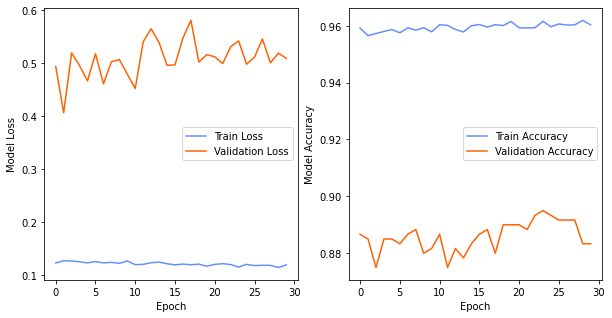

In [50]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

# look into training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# summarize history for loss
ax1.plot(fit_c.history['loss'], label = 'Train Loss', color = '#648FFF')
ax1.plot(fit_c.history['val_loss'], label = 'Validation Loss', color = '#FE6100')

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_c.history['accuracy'], label = 'Train Accuracy', color =  '#648FFF')
ax2.plot(fit_c.history['val_accuracy'], label = 'Validation Accuracy', color = '#FE6100')

ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

## Try: Data Uniformity

In the following sections we try to explore whether some bases have more likely a certain position. This would help us avoid using any columns in the following analysis, as they would not provide any additional piece of information. 
(Similar idea to a PCA analysis) 

Anyhow, all data seem to have a uniform pattern troughout all the 16 possible positions.

In [76]:
df = pd.DataFrame([list(s) for s in sx])

In [77]:
df.loc["3000_Acount"] = df[df == 'A'].count(axis = 0)/3000
df.loc["3001_Ccount"] = df[df == 'C'].count(axis = 0)/3000
df.loc["3002_Tcount"] = df[df == 'T'].count(axis = 0)/3000
df.loc["3003_Gcount"] = df[df == 'G'].count(axis = 0)/3000
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,A,A,G,G,T,C,T,G,C,C,G,G,C,C,G,A
1,C,C,T,C,C,C,T,T,A,T,G,G,G,G,G,A
2,T,C,T,C,T,C,G,G,A,A,C,T,G,T,C,A
3,G,T,T,A,A,A,C,G,T,T,A,C,A,T,C,T
4,T,T,A,A,A,T,G,C,T,G,C,T,G,A,T,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,C,G,A,T,T,G,A,A,G,T,G,T,A,C,G,A
3000_Acount,0.263,0.246667,0.255,0.246333,0.247,0.246,0.243,0.256667,0.251,0.249333,0.248667,0.254,0.244,0.258333,0.25,0.250333
3001_Ccount,0.237,0.260667,0.253,0.249,0.242,0.253333,0.257333,0.239667,0.254,0.248,0.253333,0.238,0.265,0.253667,0.254667,0.248333
3002_Tcount,0.246333,0.242,0.236667,0.251667,0.261667,0.25,0.255333,0.252333,0.250333,0.237333,0.255333,0.252,0.252,0.235,0.247667,0.241


## 15 DNA bases

Let's try to reduce the noise considering the physical properties of bases. 

**Nitrogen triplets** are the building blocks of proteins. A sequence of 16 bases contains only 5 triplets, as a base is not unpaired. 

Augmented and original data will be considered.

We will then reduce the treatment to 15 bases at a time. In the former case, we won't consider the last base in our sequences, in the latter the first one. 

In order to then augment the data, **we only shuffle triplets among themselves**, and not single bases.

In [88]:
x15 = x[:,:-4] #cutting last base from each OneHot sample
(x_train15r, y_train) = (x15[:N_train], y[:N_train])
(x_test15r, y_test) = (x15[N_train:], y[N_train:])

np.random.seed(123)
# given by numb of bases (15) times type of bases (4, for oneHotencoding)
L = 60 

#Keras model definition
model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

# model.summary()

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

fit_15_cutright = model.fit(x_train15r, y_train,
                epochs=30, batch_size = 50, validation_data = (x_test15r,y_test), shuffle = True, verbose = 0)

19/19 [==============================] - 0s 1ms/step - loss: 0.8962 - accuracy: 0.7450
Final Test loss: 0.8961780667304993
Final Test accuracy: 0.7450000047683716


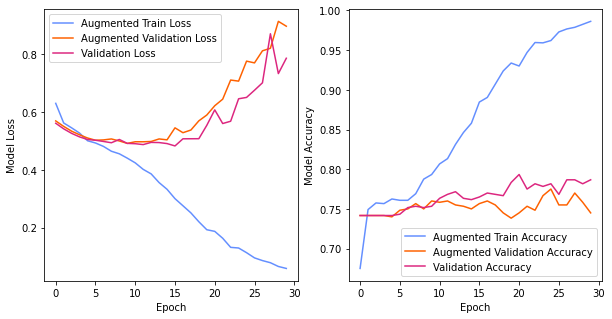

In [89]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

# look into training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# summarize history for loss
ax1.plot(fit_15_cutright.history['loss'], label = 'Augmented Train Loss',color =  '#648FFF')
ax1.plot(fit_15_cutright.history['val_loss'], label = 'Augmented Validation Loss', color = '#FE6100')
ax1.plot(fit.history['val_loss'], label = 'Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_15_cutright.history['accuracy'], label = 'Augmented Train Accuracy', color =  '#648FFF')
ax2.plot(fit_15_cutright.history['val_accuracy'], label = 'Augmented Validation Accuracy',color = '#FE6100')
ax2.plot(fit.history['val_accuracy'], label = 'Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

Unexpectedly, we notice that discarding the last base we get very similar results wrt the first case, in which we did consider all the bases. 

In principle, it means no much information is contained in the very last base. Let's test the network behaviour with augmented data

In [93]:
sx15 = [n[:-1] for n in sx]
augval15 = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(0, 15, 3)] for v,vy in zip(sx15[:N_train],y[:N_train])]).reshape(12000,2)
augsx15 = augval15[:,0]
augy_train15 = augval15[:,1].astype(int)


#Showing a sample, with the shuffle of the five triplets contained in the sequence
print(augval15[:5])

[['AAGGTCTGCCGGCCG' '1']
 ['CCGAAGGTCTGCCGG' '1']
 ['CGGCCGAAGGTCTGC' '1']
 ['TGCCGGCCGAAGGTC' '1']
 ['GTCTGCCGGCCGAAG' '1']]


In [94]:
augx_train15 = np.zeros((N_train*5,L))

for n in range(N_train*5):
    for i in range(15):
        augx_train15[n][i*4 + onehc[augsx15[n][i]]] = 1
aug_N_train = N_train*5

print(f"Augmented train data, shuffled triplets shape: {augx_train15.shape}")

Augmented data, shuffled triplets shape: (12000, 60)


In [97]:
fit_aug_cutright15 = model.fit(augx_train15, augy_train15,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True, verbose = 0)

19/19 [==============================] - 0s 1ms/step - loss: 1.2778 - accuracy: 0.8083
Final Test loss: 1.2778092622756958
Final Test accuracy: 0.8083333373069763


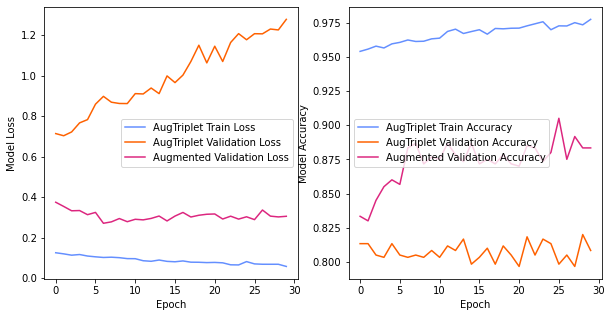

In [100]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# summarize history for loss
ax1.plot(fit_aug_cutright15.history['loss'], label = 'AugTriplet Train Loss',color =  '#648FFF')
ax1.plot(fit_aug_cutright15.history['val_loss'], label = 'AugTriplet Validation Loss', color = '#FE6100')
ax1.plot(fit_augmented.history['val_loss'], label = 'Augmented Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_aug_cutright15.history['accuracy'], label = 'AugTriplet Train Accuracy', color =  '#648FFF')
ax2.plot(fit_aug_cutright15.history['val_accuracy'], label = 'AugTriplet Validation Accuracy',color = '#FE6100')
ax2.plot(fit_augmented.history['val_accuracy'], label = 'Augmented Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

As shown, the *Augmented Random* data still outperform the 15 *Augmented Triplet* ones. 

The network may still find more useful to have more data available. 

# CASE FIRST DROP

19/19 [==============================] - 0s 1ms/step - loss: 0.8033 - accuracy: 0.8017
Final Test loss: 0.8032993078231812
Final Test accuracy: 0.8016666769981384


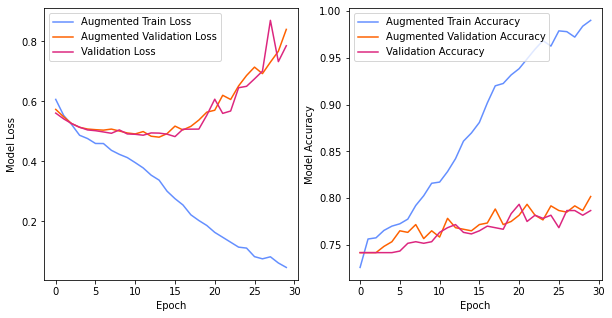

In [103]:
x15 = x[:,4:] #cutting last base from each OneHot sample
(x_train15l, y_train) = (x15[:N_train], y[:N_train])
(x_test15l, y_test) = (x15[N_train:], y[N_train:])

np.random.seed(123)
# given by numb of bases (15) times type of bases (4, for oneHotencoding)
L = 60 

#Keras model definition
model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

# model.summary()

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

fit_15_cutleft = model.fit(x_train15l, y_train,
                epochs=30, batch_size = 50, validation_data = (x_test15l,y_test), shuffle = True, verbose = 0)

# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

# look into training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# summarize history for loss
ax1.plot(fit_15_cutleft.history['loss'], label = 'Augmented Train Loss',color =  '#648FFF')
ax1.plot(fit_15_cutleft.history['val_loss'], label = 'Augmented Validation Loss', color = '#FE6100')
ax1.plot(fit.history['val_loss'], label = 'Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_15_cutleft.history['accuracy'], label = 'Augmented Train Accuracy', color =  '#648FFF')
ax2.plot(fit_15_cutleft.history['val_accuracy'], label = 'Augmented Validation Accuracy',color = '#FE6100')
ax2.plot(fit.history['val_accuracy'], label = 'Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

['AGGTCTGCCGGCCGA' 'CGAAGGTCTGCCGGC' 'GGCCGAAGGTCTGCC' 'GCCGGCCGAAGGTCT'
 'TCTGCCGGCCGAAGG']
Augmented train data, shuffled triplets shape: (12000, 60)
19/19 [==============================] - 0s 1ms/step - loss: 1.4644 - accuracy: 0.8517
Final Test loss: 1.4644110202789307
Final Test accuracy: 0.8516666889190674


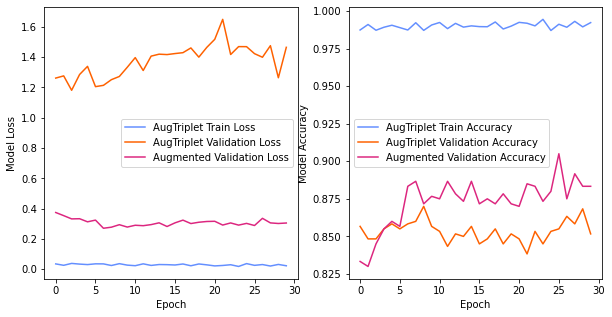

In [114]:
sx15Left = [n[1:] for n in sx]
augval15 = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(0, 15, 3)] for v,vy in zip(sx15Left[:N_train],y[:N_train])]).reshape(12000,2)
augsx15 = augval15[:,0]
augy_train15 = augval15[:,1].astype(int)

augsx15

augx_train15 = np.zeros((N_train*5,L))
print(augsx15[:5])
for n in range(N_train*5):
    for i in range(15):
        augx_train15[n][i*4 + onehc[augsx15[n][i]]] = 1
aug_N_train = N_train*5

print(f"Augmented train data, shuffled triplets shape: {augx_train15.shape}")

fit_aug_cutright15 = model.fit(augx_train15, augy_train15,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True, verbose = 0)

# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# summarize history for loss
ax1.plot(fit_aug_cutright15.history['loss'], label = 'AugTriplet Train Loss',color =  '#648FFF')
ax1.plot(fit_aug_cutright15.history['val_loss'], label = 'AugTriplet Validation Loss', color = '#FE6100')
ax1.plot(fit_augmented.history['val_loss'], label = 'Augmented Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_aug_cutright15.history['accuracy'], label = 'AugTriplet Train Accuracy', color =  '#648FFF')
ax2.plot(fit_aug_cutright15.history['val_accuracy'], label = 'AugTriplet Validation Accuracy',color = '#FE6100')
ax2.plot(fit_augmented.history['val_accuracy'], label = 'Augmented Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

In the Drop-First case, we achieve a similar result w.r.t. what we got in the case of random shuffling, with a third of the training samples. Accuracy in particular is close in both cases.

Let's consider now the actual shuffle of triplets, as we can get 5! sequences randomly shuffling the triplets.

In [165]:
augval15 = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(0, 15, 3)] for v,vy in zip(sx15Left[:N_train],y[:N_train])]).reshape(12000,2)
ccc = [ [v[i:i+3] for i in range(0,15,3)] for v in sx15Left[:N_train]]

In [ ]:
import itertools

#Produce triplets permutation in the dataset

perms = [  [list(itertools.permutations(trip)), label] for trip, label in zip(ccc,y[:N_train]) ]
labels_vec = []
trdata_vec = []
for p in perms: 
    for trip in p[0]:
        trdata_vec.append(''.join(trip))
        labels_vec.append(p[1])
        


In [174]:
#OneHot Encoding

trdataONEHOT = np.zeros((288000,L))
for n in range(288000):
    for i in range(15):
        trdataONEHOT[n][i*4 + onehc[trdata_vec[n][i]]] = 1




[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


In [179]:
fit_allPerms = model.fit(trdataONEHOT, np.array(labels_vec),
                 epochs=30, batch_size = 512, validation_data = (x_test15l,y_test), shuffle = True)


Epoch 1/30
563/563 [==============================] - 2s 3ms/step - loss: 0.5585 - accuracy: 0.7467 - val_loss: 0.4087 - val_accuracy: 0.7483
Epoch 2/30
563/563 [==============================] - 1s 3ms/step - loss: 0.4291 - accuracy: 0.7776 - val_loss: 0.3782 - val_accuracy: 0.7717
Epoch 3/30
563/563 [==============================] - 1s 2ms/step - loss: 0.4041 - accuracy: 0.7931 - val_loss: 0.3632 - val_accuracy: 0.7900
Epoch 4/30
563/563 [==============================] - 1s 2ms/step - loss: 0.3856 - accuracy: 0.8048 - val_loss: 0.3601 - val_accuracy: 0.8000
Epoch 5/30
563/563 [==============================] - 1s 2ms/step - loss: 0.3710 - accuracy: 0.8139 - val_loss: 0.3458 - val_accuracy: 0.8250
Epoch 6/30
563/563 [==============================] - 1s 3ms/step - loss: 0.3582 - accuracy: 0.8213 - val_loss: 0.3398 - val_accuracy: 0.8300
Epoch 7/30
563/563 [==============================] - 2s 3ms/step - loss: 0.3471 - accuracy: 0.8275 - val_loss: 0.3403 - val_accuracy: 0.8333
Epoch 

19/19 [==============================] - 0s 2ms/step - loss: 0.9177 - accuracy: 0.8150
Final Test loss: 0.9177437424659729
Final Test accuracy: 0.8149999976158142


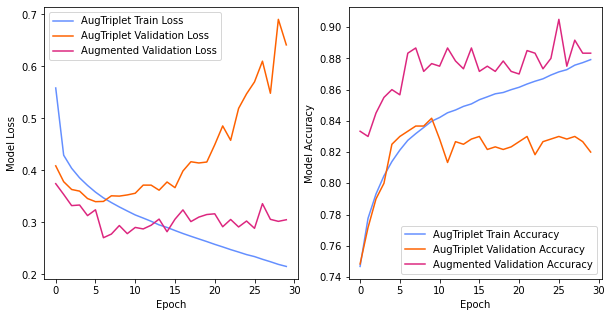

In [180]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# summarize history for loss
ax1.plot(fit_allPerms.history['loss'], label = 'AugTriplet Train Loss',color =  '#648FFF')
ax1.plot(fit_allPerms.history['val_loss'], label = 'AugTriplet Validation Loss', color = '#FE6100')
ax1.plot(fit_augmented.history['val_loss'], label = 'Augmented Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_allPerms.history['accuracy'], label = 'AugTriplet Train Accuracy', color =  '#648FFF')
ax2.plot(fit_allPerms.history['val_accuracy'], label = 'AugTriplet Validation Accuracy',color = '#FE6100')
ax2.plot(fit_augmented.history['val_accuracy'], label = 'Augmented Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

As we can see the results are similar to the previous permutation, with a slight improvement in the final test accuracy. However, the training set is again outperformed by the the standard augmented one.